In [1]:
import numpy as np
import cv2 as cv

img = cv.imread('../sakktabla.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# 1. FAST inicializálása NMS-sel (ez az alapértelmezett, és ez kell neked!)
fast = cv.FastFeatureDetector_create(threshold=15, nonmaxSuppression=True)

# 2. Detektálás
kp = fast.detect(gray, None)

# 3. SUBPIXEL FINOMÍTÁS (Ez a titkos fegyvered a pontos rácshoz!)
# A drawKeypoints csak egész pixeleket tud rajzolni, de a rácshoz kell a tizedespont pontosság
points = np.array([p.pt for p in kp], dtype=np.float32)
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.001)
refined_points = cv.cornerSubPix(gray, points, (5, 5), (-1, -1), criteria)

# 4. Megjelenítés a kényelmes függvénnyel
# (Itt a 'kp' objektumokat használjuk, hogy lássuk az eredményt)
img_result = cv.drawKeypoints(img, kp, None, color=(0, 255, 0), flags=0)

cv.imwrite('optimalis_fast.png', img_result)

# A 'refined_points' változót pedig küldhetjük tovább a hisztogram készítőnek

True

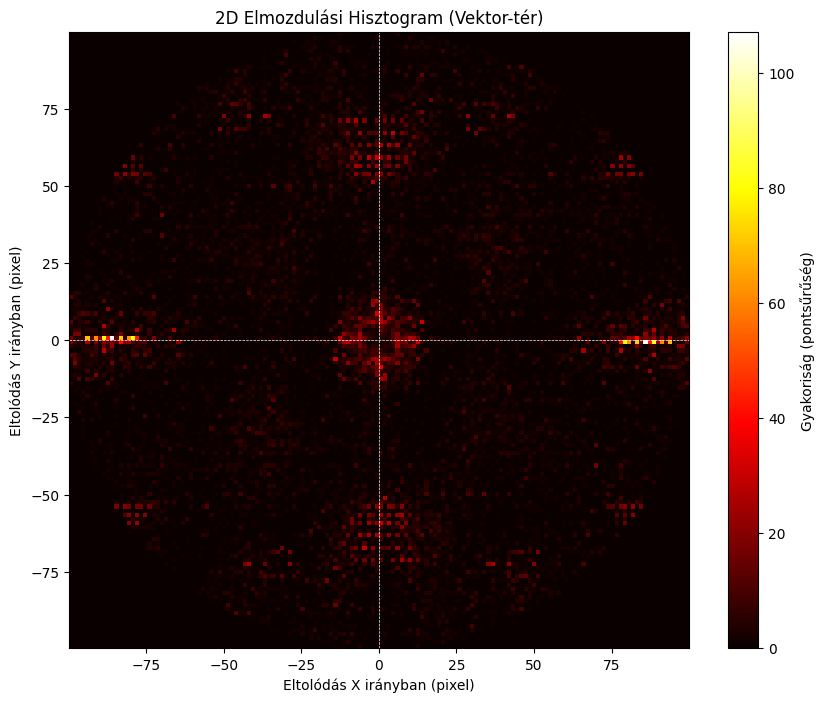

In [2]:
import matplotlib.pyplot as plt

def plot_displacement_histogram(points, max_dist=100, bin_size=150):
    """
    Kiszámolja és kirajzolja a pontok közötti elmozdulásvektorok 2D hisztogramját.
    """
    dxs = []
    dys = []
    
    # Minden pontot összevetünk minden másikkal (statisztikai minta)
    # Ha túl sok pontod van, érdemes lehet mintavételezni
    for i in range(len(points)):
        # Kiszámoljuk az i-edik pont távolságát az összes többitől
        diffs = points - points[i]
        
        # Csak a releváns távolságon belüli (max_dist) vektorokat tartjuk meg
        # A (0,0) elmozdulást (önmaga) kihagyjuk, hogy ne nyomja el a többi csúcsot
        dist = np.linalg.norm(diffs, axis=1)
        mask = (dist < max_dist) & (dist > 1) 
        
        filtered_diffs = diffs[mask]
        dxs.extend(filtered_diffs[:, 0])
        dys.extend(filtered_diffs[:, 1])

    # Megjelenítés Matplotlib segítségével
    plt.figure(figsize=(10, 8))
    
    # 2D hisztogram létrehozása
    # A 'hot' vagy 'viridis' colormap jól mutatja a gócpontokat
    h, xedges, yedges, image = plt.hist2d(dxs, dys, bins=bin_size, cmap='hot')
    
    plt.colorbar(label='Gyakoriság (pontsűrűség)')
    plt.title('2D Elmozdulási Hisztogram (Vektor-tér)')
    plt.xlabel('Eltolódás X irányban (pixel)')
    plt.ylabel('Eltolódás Y irányban (pixel)')
    
    # Középpont jelölése (itt lenne a 0,0)
    plt.axhline(0, color='white', lw=0.5, ls='--')
    plt.axvline(0, color='white', lw=0.5, ls='--')
    
    plt.show()
    
    return h, xedges, yedges

# Használat (a korábbi 'refined_points' változóval):
h, x_edges, y_edges = plot_displacement_histogram(refined_points)

In [ ]:
from scipy.ndimage import maximum_filter

def extract_basis_vectors(H, xedges, yedges, threshold_ratio=0.5):
    # 1. Lokális maximumok keresése a hisztogramon
    # A maximum_filter segít megtalálni a csúcsokat
    data_max = maximum_filter(H, size=5)
    maxima = (H == data_max) & (H > np.max(H) * threshold_ratio)
    
    # Csúcsok koordinátáinak kinyerése
    labeled, num_objects = None, None # Itt egyszerűen indexeket keresünk
    y_coords, x_coords = np.where(maxima)
    
    peaks = []
    for i in range(len(x_coords)):
        # Átváltjuk a hisztogram indexeket pixel-eltolódás értékké
        dx = (xedges[x_coords[i]] + xedges[x_coords[i]+1]) / 2
        dy = (yedges[y_coords[i]] + yedges[y_coords[i]+1]) / 2
        # A középpontot (0,0) kihagyjuk
        if np.linalg.norm([dx, dy]) > 10:
            peaks.append([dx, dy, H[y_coords[i], x_coords[i]]])
            
    # Rendezés fényerő szerint
    peaks = sorted(peaks, key=lambda x: x[2], reverse=True)
    
    # Kiválasztjuk a két legfontosabb, nem egy irányba mutató vektort
    u = np.array(peaks[0][:2])
    v = None
    for i in range(1, len(peaks)):
        candidate = np.array(peaks[i][:2])
        # Megnézzük, hogy ne ugyanaz az irány legyen (koszinusz hasonlóság)
        cos_sim = np.abs(np.dot(u, candidate) / (np.linalg.norm(u) * np.linalg.norm(candidate)))
        if cos_sim < 0.8: # Ha elég különböző az irány
            v = candidate
            break
            
    return u, v

# Használat:
u, v = extract_basis_vectors(H, x_edges, y_edges)
print(f"Az első bázisvektor (u): {u}")
print(f"A második bázisvektor (v): {v}")

ModuleNotFoundError: No module named 'scipy'